University of Tuebingen \
DataLiteracy course -  Group Project 2023/2024 \
Authors: Johannes Bertram, Felix Böhm, Nadja Buttke, Fabian Morelli 

# Project Figures for Visualizing impact of gain classes

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tueplots import bundles
from tueplots.constants.color import rgb
from tueplots import cycler, markers
from tueplots.constants import markers as marker_constants
from tueplots.constants.color import palettes

# Import data

In [12]:
gain_dict = {}
main_folder_path = '../dat/gain-comparison'
for foldername in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, foldername)

    folder_dict = {}

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            
            key_city = filename.split('_')[2].replace(".json", "")
            key_city = key_city.replace('ä', 'ae').replace('ö', 'oe').replace('ü', 'ue')

            df = pd.read_json(file_path, orient='index')
            df.index = df.index.str.replace('ä', 'ae').str.replace('ö', 'oe').str.replace('ü', 'ue')
            folder_dict[key_city] = df
    
    gain_dict[foldername] = folder_dict

# Mean Delay for each switch time and each gain type

In [13]:
dict_mean_delays = {}


# data processing

# iterate over different gain assumptions
for key_gain, df_dict in gain_dict.items():
    print(key_gain)


    switch_times_array = list(range(1,61,1))
    empty = pd.DataFrame(columns=['switch_times', 'mean_delay', 'reachable1', 'reachable2', 'reachable3'])
    empty.switch_times = switch_times_array
    empty['mean_delay'] = [[] for _ in range(60)]
    empty.loc[:, ['reachable1', 'reachable2', 'reachable3']] = 0


    # -------------------

    delay_matrix = [[] for _ in range(60)]

    # iterate all dfs in gain assumption
    for key, df in df_dict.items():
        
        for irow, row in df.iterrows():
            

            for i, minute in enumerate(row['switch time']):
                
                delay = row['delay'][i]

                delay_matrix[int(minute-1)].append(delay)

                # Fill the reachable columns
                case = row['reachable'][i]
                if case == 1:
                    empty.loc[minute-1, 'reachable1'] += 1
                elif case == 2:
                    empty.loc[minute-1, 'reachable2'] += 1
                elif case == 3:
                    empty.loc[minute-1, 'reachable3'] += 1
                
                

    means = []
    #medians = []
    for minute in delay_matrix:
        means.append(np.mean(minute).round(2))
        #medians.append(np.median(minute).round(2))

    empty['mean_delay'] = means
    df_mean_delays = empty

    dict_mean_delays[key_gain] = df_mean_delays


zero_gain
no_wait
theoretical_max_gain
avg_gain
avg_pos_gain


In [14]:
print(dict_mean_delays.keys())
dict_mean_delays['avg_gain'].head(5)

dict_keys(['zero_gain', 'no_wait', 'theoretical_max_gain', 'avg_gain', 'avg_pos_gain'])


,switch_times,mean_delay,reachable1,reachable2,reachable3
0,1,71.92,4179,35861,22395
1,2,55.54,5535,51411,59071
2,3,59.96,933,7951,9492
3,4,65.34,936,6027,5826
4,5,50.82,2178,6133,9573


### Plot

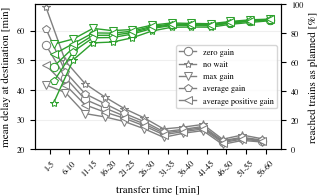

In [16]:
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.rcParams.update(cycler.cycler(marker=marker_constants.o_sized[:5]))
plt.rcParams.update(markers.inverted())


group_size = 5  # set group size 

# FIGURE ------------------------------

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


keys_string = ['zero gain', 'no wait', 'max gain', 'average gain', 'average positive gain']

width = 0.3

max_grouped_meand_delays = []


# iterate over gain assumptions
for key, df in dict_mean_delays.items():

    m = list(dict_mean_delays.keys()).index(key) # iterate markers
    

    grouped_mean_delays = []
    #grouped_median_delays = []
    grouped_reachable1 = []
    grouped_reachable2 = []
    grouped_reachable3 = []

    for i in range(0, len(df.switch_times), group_size):
        group_sum_mean_delays = np.sum(df.mean_delay[i:i+group_size])
        grouped_mean_delays.append(group_sum_mean_delays)


        group_sum_reachable1 = np.sum(df.reachable1[i:i+group_size])
        grouped_reachable1.append(group_sum_reachable1)

        group_sum_reachable2 = np.sum(df.reachable2[i:i+group_size])
        grouped_reachable2.append(group_sum_reachable2)

        group_sum_reachable3 = np.sum(df.reachable3[i:i+group_size])
        grouped_reachable3.append(group_sum_reachable3)



    #print(len(grouped_mean_delays))
    max_grouped_meand_delays.append(max(grouped_mean_delays)/group_size)
    x = np.arange(len(grouped_mean_delays))

    l1 = ax1.plot(x+1-0.2, np.array(grouped_mean_delays)/group_size, color="grey", label=keys_string[m], linewidth=1) 

    
    bottom = np.zeros(len(grouped_mean_delays))

    reachables_total = np.array(grouped_reachable1) + np.array(grouped_reachable2) + np.array(grouped_reachable3)
    bar1 = np.array(grouped_reachable1)/reachables_total*100
    bar2 = np.array(grouped_reachable2)/reachables_total*100
    bar3 = np.array(grouped_reachable3)/reachables_total*100


    l2 = ax2.plot(x+1+0.2, bar3, color="#2CA02C", label=keys_string[m], linewidth=1) 

    m = m+1



ax1.set_xlabel('transfer time [min]')
ax1.set_ylabel('mean delay at destination [min]')
xticks_array =  [f'{start}-{end}' for start, end in zip(range(1, 60, group_size), range(1 + group_size - 1, 60 + 1, group_size))]
ax1.set_xticks(x+1, xticks_array, rotation=45)
#ax1.set_yticks(y_ticks_array)
ax1.set_ylim([20, math.ceil(max(max_grouped_meand_delays))])
ax1.yaxis.grid("major", alpha=0.2)


ax2.set_ylabel("reached trains as planned [%]")
ax2.set_ylim([0,100])

# Solution for having two legends
bars1, labels1 = ax1.get_legend_handles_labels()
#bars2, labels2 = ax2.get_legend_handles_labels()


#legend = ax2.legend([bars1[0], bars2[0]], [labels1[0], labels2[0]], loc="lower left")
legend = ax2.legend(bars1, labels1, loc="center right", labelcolor="black")
for lh in legend.legend_handles:
    lh.set_alpha(1.0)

    


plt.savefig("plot_meanDelay_gain.pdf", format="pdf")

plt.show()